# Prediction de la survie d'un individu sur le Titanic 🚢

<img src="https://media.vogue.fr/photos/5faac06d39c5194ff9752ec9/2:3/w_1920,c_limit/076_CHL_126884.jpg" width="200">


Ce tutoriel repose sur les données et le défi exemple de la communauté kaggle sur les données du titanic.

Il s'agit à partir de la liste des passagers du titanic et de leur survie ou non de prédire la chance de survie d'un individu en fonction de son nom, age, sexe, situation familiale, économique...

Ce notebook est inspiré par https://www.kaggle.com/mukultiwari/titanic-top-14-with-random-forest

In [2]:
import pandas as pd ; import numpy as np
import matplotlib.pyplot as plt
import multiprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import pathlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
import time
import os
%matplotlib inline
#import warnings
#warnings.filterwarnings('ignore')

## Données

On va utiliser la librairie `pandas` pour lire les données, on y a déposé le jeu de donnée disponible sur Kaggle :

* le `train.csv` contient les données d'apprentissage, c'est-à-dire les variables décrivants des individus et s'ils ont survécus ou non ;
* le `test.csv` contient uniquement la description d'individu dont il faut prédire les chances de survie. 

In [65]:
#os.chdir('/home/coder/work/ensae-reproductibilite-application')

TrainingData = pd.read_csv('train.csv')
TrainingData.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [61]:
TrainingData['Ticket'].str.split("/").str.len()

0      2
1      1
2      2
3      1
4      1
      ..
886    1
887    1
888    2
889    1
890    1
Name: Ticket, Length: 891, dtype: int64

In [62]:
TrainingData['Name'].str.split(",").str.len()

0      2
1      2
2      2
3      2
4      2
      ..
886    2
887    2
888    2
889    2
890    2
Name: Name, Length: 891, dtype: int64

Avec la méthode `.info`, on pourrait vérifier que notre _dataset_ a :

* 7 variables numériques : `PassengerId, Survived, Pclass, Age, SibSp, Parch, Fare`
    * dont `PassengerId` qui est l'identifiant du passager dans le dataset
    * dont `Survived` qui est la variable à prédire la variable _"cible"_
    * dont `PClass` qui est une indication de la strate socio économique
    * dont  `SibSp` et `Parch` qui permettent de déterminer la situation familiale (époux, mère, fille...)
    * `Fare` qui est un prix.
* 5 variables non numériques : `Name, Sex, Ticket` un identifiant de ticket, `Cabin` un identifiant de cabin, `Embarked` le port d'embarquation (_C = Cherbourg, Q = Queenstown, S = Southampton_)

In [44]:
n_trees = 20
max_depth =None
max_features='sqrt'

## Valeurs manquantes

In [45]:
TrainingData.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

Comme généralement en machine learning, il va falloir traiter ces valeurs manquantes en imputant des valeurs :
* dans le train dataset ( Age 177 manquants, Cabin 687 manquants, Embarked 2 manquants)
* dans le test dataset ( Age 86 manquants, Cabin 327 manquants, Fare 1 manquant)

## Un peu d'exploration et de feature engineering

Avant d'entrainer un modèle, il y a généralement une phase exploratoire du dataset que nous allons réduire ici au minimum.
Il y a aussi selon le contexte du feature engineering qui est probablement l'une des composantes les plus compliquées du machine learning, il s'agit selon le contexte et le problème de créer des variables qui ont un sens pour contribuer à résoudre notre problématique.

Ici, on peut en faire un exemple naturellement sur le nom de l'invidu et instinctivement en extrayant le titre du nom des individus, mais cela peut etre beaucoup moins naturel selon les problèmes voire même complètement un état de l'art si on prend l'exemple de la modélisation des images pour le machine learning ou il s'agit, par exemple, de proposer des valeurs pondérées par sous division de partie d'image.

### Statut socioéconomique

Une variable catégorique qui donne une idée de la classe socio-économique de la personne dont on donne un exemple avec seaborn pour visualiser la contribution https://seaborn.pydata.org/

Clairement chaque classe n'avait pas la meme chance de survie, n'est ce pas Jack?

In [46]:
import seaborn as sns

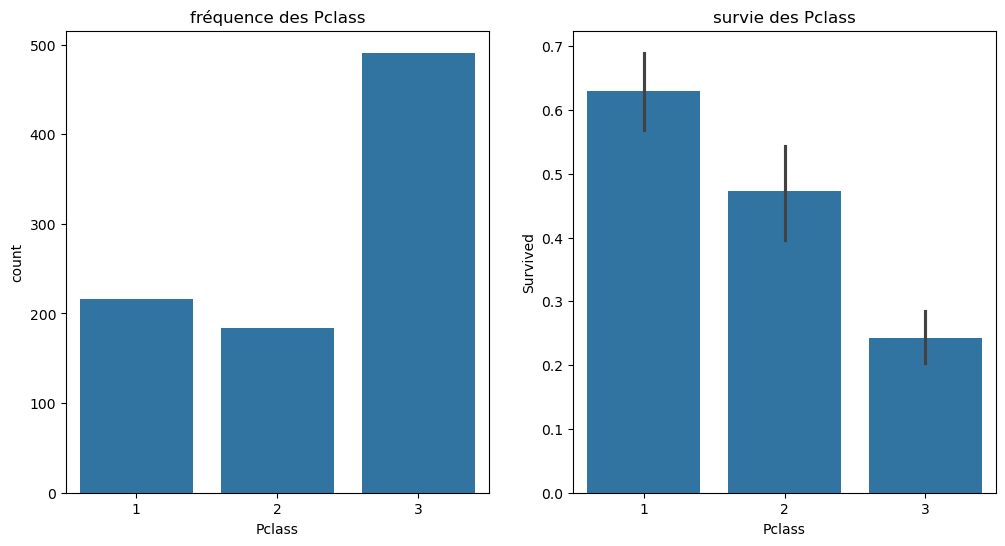

In [47]:
fig, axes=plt.subplots(1,2, figsize=(12, 6)) #layout matplotlib 1 ligne 2 colonnes taile 16*8
fig1_pclass=sns.countplot(data=TrainingData, x ="Pclass",    ax=axes[0]).set_title("fréquence des Pclass")
fig2_pclass=sns.barplot(data=TrainingData, x= "Pclass",y= "Survived", ax=axes[1]).set_title("survie des Pclass")

### Age

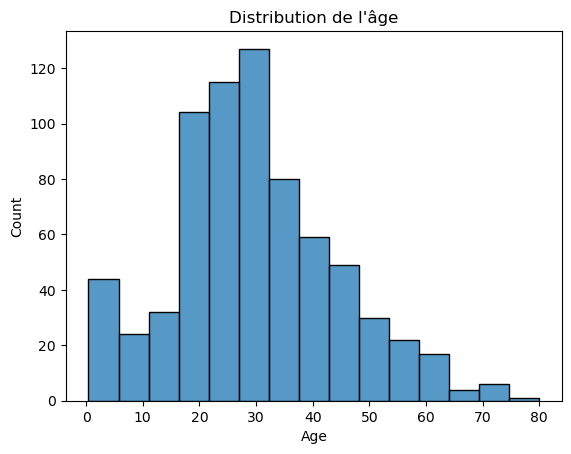

In [48]:
sns.histplot(data= TrainingData, x='Age',bins=15, kde=False    )    .set_title("Distribution de l'âge")
plt.show()

## Encoder les données imputées ou transformées.

A partir de cette analyse rapide, on va proposer les transformations suivantes:

- `Age`: il nous faut traiter les `Null`, on impute à la moyenne même s'il y a mieux à faire...
- `Embarked`: il a 2 valeurs manquantes qu'on ajoute à la valeur la plus fréquente _S_
- `Fare` : même sort que `Age` on impute à la moyenne
- `hasCabin` : Le nombre de `Null` étant importante on va ajouter la variable  1 ou 0 pour ne retenir que si la personne avait une cabine ou non

In [49]:
# Voila nos données d'apprentissage
TrainingData.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [50]:
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

numeric_features=["Age", "Fare"]
categorical_features=["Embarked", "Sex"]

numeric_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")),
("scaler", MinMaxScaler()),])

categorical_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")),("onehot", OneHotEncoder()),])


preprocessor = ColumnTransformer(
transformers=[
("Preprocessing numerical", numeric_transformer, numeric_features),
(
"Preprocessing categorical",
categorical_transformer,
categorical_features,
),
        ]
    )

In [51]:
pipe = Pipeline(
        [
            ("preprocessor", preprocessor),
            ("classifier", RandomForestClassifier(n_estimators=20)),
        ]
    )
pipe

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Preprocessing numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('Preprocessing categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Embarked', 'Sex'])])),
                ('classifier', RandomForestClassifier(n_estimators=20))])

On _split_ notre _dataset_ d'apprentisage pour faire de la validation croisée une partie pour apprendre une partie pour regarder le score.

Prenons arbitrairement 10% du dataset en test et 90% pour l'apprentissage.

In [52]:
y = TrainingData["Survived"]
X = TrainingData.drop("Survived", axis = 'columns')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
pd.concat([X_train, y_train]).to_csv("train.csv")
pd.concat([X_test, y_test]).to_csv("test.csv")

In [53]:
jetonapi = "$trotskitueleski1917"

# Random Forest

Les forets aléatoires sont des algorithmes souvent performants en ce qui concerne les classifications.

L'idée est simple :
* On prend dans le dataset une partie des données et une partie des variables au hasard.
* On fait un arbre de décision sur ces données tirées aléatoirement, l'arbre de décision étant un algorithme permettant de déterminer la variable et sa valeur qui permet de séparer au mieux la population par rapport à notre variable cible le but étant de descendre aux feuilles les plus pures.

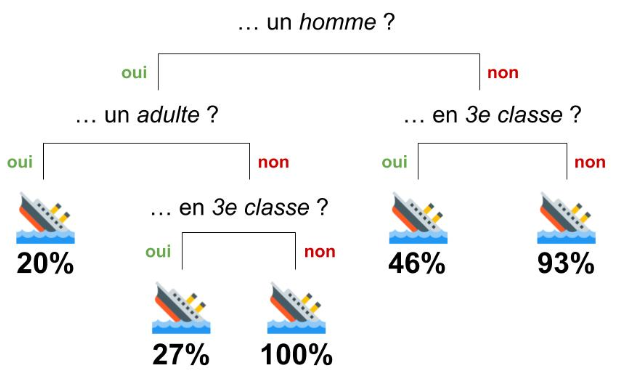

* Puis on recommence avec une autre sous partie des données et des variables, ce qui nous fait un second arbre...
* Du coup, plusieurs arbres aléatoires, ca nous fait une forêt...aléatoire.
* Un individu à prédire passera dans chacun des arbres et aura pour chaque arbre une prédiction, la prédiction finale étant la pondération de chacun de nos arbres.


In [54]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import pathlib
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier

In [55]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('Preprocessing numerical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('Preprocessing categorical',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder())]),
                                                  ['Embarked', 'Sex'])])),
                ('classifier', RandomForestClassifier(n_estimators=20))])

In [56]:
#calculons le score sur le dataset d'apprentissage et sur le dataset de test (10% du dataset d'apprentissage mis de côté)
# le score étant le nombre de bonne prédiction
rdmf_score = pipe.score(X_test, y_test)
rdmf_score_tr = pipe.score(X_train, y_train)
print(f"{rdmf_score:.1%} de bonnes réponses sur les données de test pour validation")
from sklearn.metrics import confusion_matrix
print(20*"-")
print("matrice de confusion")
print(confusion_matrix(y_test, pipe.predict(X_test)))

81.1% de bonnes réponses sur les données de test pour validation
matrice de confusion


array([[44, 10],
       [ 7, 29]])